# Atribución Automática de Autoría de publicaciones en foros

#### Solución de software para la asignatura de TFG del Grado en Ingeniería Informática de la UNIR

###### Autor: José Herce Preciado

In [1]:
from tfg.textmining.preprocessing import eliminar_columnas, show_statistics, select_documents
from tfg.textmining.preparing import clean_corpus, process_dataset
from tfg.modelos import classifiers
from tfg.datos import get_experiment_id, DataBase, load_temp_dataset, save_temp_dataset, anonymize_authors

## PARÁMETROS CONFIGURACIÓN EXPERIMENTO

In [2]:
###############################################################################
# Manipulación de los datos
###############################################################################
origen_datos = "mongo"  # "local" o "mongo" - Si "local" se cargará el dataset desde el disco. Si "mongo" se cargará desde la base de datos.
save_preprocessed_temp = False  # Si True, se guardará el dataset preprocesado en el disco.
# Anonimización de los datos - Si True, se guardará el dataset anonimizado en la base de datos
anonymize_and_save = False  # Si False, se anonimizarán los datos pero no se guardarán en la base de datos
collection_name = "anonimizado_util"  # Nombre de la colección en la que se guardarán los datos anonimizados
collection_data = "anonymized_posts_100"  # Nombre de la colección del data set

collection = collection_data

###############################################################################
# Preprocesamiento de los datos
###############################################################################
description = "Prueba"
n_authors = 10  # 200,
min_words = 30  # 30,
max_words = None  # None,
min_doc_per_author = None  # 100,
max_doc_per_author = 1000  # None # 1000 # Si longest_docs=False se dará error en caso de no existir documentos suficientes para algún autor.
longest_docs = False  # True: Seleccionar los documentos más largos. False: Seleccionar los documentos aleatoriamente.
# Estadísticas y gráficas
show_stats = False
num_bars = 'auto'  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.

description = f"3 autores minimo {min_words} palabras sin documentos minimos, balanceo pasivo- LIMPIANDO y NO TOKENIZANOD - TRIGRAMAS"

###############################################################################
# Limpieza de los datos
###############################################################################
mis_tecnicas = False
stop_words=False
max_df=0.8  # Palabras muy frecuentes
min_df=1  # Palabras poco frecuentes
strip_accents=False
lowercase=False

# True: Tokenizar; False: Eliminar; None: No hacer nada
tokenize_emoticons = True
tokenize_numbers = True
tokenize_simbols = True
tokenize_punctuation = True
tokenize_urls = True


###############################################################################
# Tokenización de los datos
###############################################################################
ngram_range=(1, 3)
binarize=False
balance='all_set'  # 'all_set' 'sub_set'
balance_to_target=False
target=None  # Clase objetivo binarización
balance_passive=True

###############################################################################
# Extracción de características de los datos
###############################################################################
test_size=0.3
sublinear_tf=True # Apply sublinear tf scaling, i.e. replace tf with 1 + log(tf). Default: False.
smooth_idf=True  # Smooth idf weights by adding one to document frequencies, as if an extra document was seen containing every term in the collection exactly once. Prevents zero divisions. Default: True.
use_idf=True  # Enable inverse-document-frequency reweighting. If False, idf(t) = 1. Default: True.

# TODO No propagada al Vectorizador
norm='l2'  # Each output row will have unit norm, either: Default: 'l2'
           #    'l2': Sum of squares of vector elements is 1. The cosine similarity between two vectors is their dot product when l2 norm has been applied.
           #    'l1': Sum of absolute values of vector elements is 1. See preprocessing.normalize.
           #    None: No normalization.


###############################################################################
# Clasificación de los datos
###############################################################################
classifiers_list = [
    'RidgeClassifier',
    'LogisticRegression',
    'BernoulliNB',
    'NearestCentroid',
    'LinearSVC',
    # 'NuSVC',
    # 'SVC',
    # 'RandomForestClassifier',
    # 'DecisionTreeClassifier',
    'ExtraTreeClassifier',
    # 'GradientBoostingClassifier',
    # 'LogisticRegressionCV',
    # 'RidgeClassifierCV',
    # 'MLPClassifier',
]


# description = "Sin limitar numero de palabras y tokenizando el texto"


In [3]:

metadata = dict(_id=get_experiment_id())
metadata["description"] = description
db = DataBase(collection=collection)

## Minería de texto

### Fase de recolección de datos

In [4]:

if origen_datos == "local":
    print("Cargando datos desde el disco...")
    df_all = load_temp_dataset()
elif origen_datos == "mongo":
    print("Cargando datos desde la base de datos...")
    df_all = db.get_dataframe(collection=collection)
    save_temp_dataset(df_all)
else:
    raise ValueError("El parámetro origen_datos debe ser 'local' o 'mongo'")
df_all.info()

Cargando datos desde la base de datos...
Cargando datos desde la base de datos...
Guardar fichero: ./tmp/temp_dataset.pkl
Objeto guardado en el archivo temp_dataset.pkl
Tiempo de guardado: 1.554

Recuperados 905129 documentos de la colección anonymized_posts_100 en 5.280 segundos.

Guardar fichero: ./tmp/temp_dataset.pkl
Objeto guardado en el archivo temp_dataset.pkl
Tiempo de guardado: 1.521

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905129 entries, 0 to 905128
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   _id     905129 non-null  object
 1   text    905129 non-null  object
 2   author  905129 non-null  object
dtypes: object(3)
memory usage: 20.7+ MB


In [5]:
df_all.count()

_id       905129
text      905129
author    905129
dtype: int64

### Fase de preprocesamiento

In [6]:

df_all = eliminar_columnas(df_all, ["_id", "fecha", "numeroEntrada", "cita", "url", "tipoUsuario", "thread"])
df_all.info()

Eliminando columnas:  ['_id']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 905129 entries, 0 to 905128
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    905129 non-null  object
 1   author  905129 non-null  object
dtypes: object(2)
memory usage: 13.8+ MB


In [7]:
_ = show_statistics(df_all, title="Estadísticas del dataset completo",
                    num_bars='auto',  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
                    hist=False)

******************************************************************************************
Estadísticas del dataset completo:
******************************************************************************************
 - Número de autores                  :      1,362
 - Número de documentos               :    905,129
 - Número de palabras                 : 28,625,756
 - Máximo de documentos de un autor   :     38,595
 - Mínimo de documentos de un autor   :        100
 - Media de documentos por autor      :        664.56
 - SD de documentos por autor         :      1,865.79
 - CV de documentos por autor (%)     :        280.76
 - Máximo de palabras de un autor     :    480,778
 - Mínimo de palabras de un autor     :        609
 - Media de palabras por autor        :     21,017.44
 - SD de palabras por autor           :     35,472.92
 - CV de palabras por autor (%)       :        168.78
 - Máximo de palabras de un documento :     19,130
 - Mínimo de palabras de un documento :          1


In [8]:
###############################################################################
# Seleccionar dataset
###############################################################################
datos, metadata = select_documents(
    df_all,
    n_authors=n_authors,  # 200,
    min_words=min_words,  # 30,
    max_words=max_words,  # None,
    min_doc_per_author=min_doc_per_author,  # 100,
    max_doc_per_author=max_doc_per_author,
    # 1000,  # Si longest_docs=False se dará error en caso de no existir documentos suficientes para algún autor.
    longest_docs=longest_docs,
    # True: Seleccionar los documentos más largos. False: Seleccionar los documentos aleatoriamente.
    show_stats=show_stats,
    num_bars=num_bars,  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
    metadata=metadata,
)
# metadata["selected_documents_statistics"] = md
# metadata = dict(selected_documents_statistics=metadata)

In [9]:
_ = show_statistics(datos, title="Estadísticas del dataset seleccionado",
                    num_bars='auto',  # 'auto', 'fd', 'doane', 'scott', 'stone', 'rice', 'sturges', or 'sqrt'.
                    hist=False)

******************************************************************************************
Estadísticas del dataset seleccionado:
******************************************************************************************
 - Número de autores                  :         10
 - Número de documentos               :     10,000
 - Número de palabras                 :    727,406
 - Máximo de documentos de un autor   :      1,000
 - Mínimo de documentos de un autor   :      1,000
 - Media de documentos por autor      :      1,000.00
 - SD de documentos por autor         :          0.00
 - CV de documentos por autor (%)     :          0.00
 - Máximo de palabras de un autor     :    117,192
 - Mínimo de palabras de un autor     :     49,934
 - Media de palabras por autor        :     72,740.60
 - SD de palabras por autor           :     23,798.04
 - CV de palabras por autor (%)       :         32.72
 - Máximo de palabras de un documento :      4,662
 - Mínimo de palabras de un documento :        

In [10]:
# Anonimizar autores
if anonymize_and_save:
    db = DataBase()
    anonymized_df_all = db.anonymize_and_save(datos, collection="all_anonymized_posts")
    # anonymized_df_all = anonymize_authors(df_all)
    datos = anonymized_df_all
else:
    datos = anonymize_authors(datos)
# Guardar datos preprocesados en el disco
if save_preprocessed_temp:
    save_temp_dataset(datos)

Prefix: A
Changing author AUTHOR_161 to A0
Changing author AUTHOR_165 to A1
Changing author AUTHOR_206 to A2
Changing author AUTHOR_30 to A3
Changing author AUTHOR_38 to A4
Changing author AUTHOR_431 to A5
Changing author AUTHOR_55 to A6
Changing author AUTHOR_6 to A7
Changing author AUTHOR_93 to A8
Changing author AUTHOR_97 to A9


In [11]:
author_label = "author"
doc_author_counts = datos[author_label].value_counts()
print("Número de autores: {}".format(len(doc_author_counts)))
word_author_counts = datos.groupby(author_label)['text'].apply(lambda x: x.str.split().str.len().sum())
print("Número de documentos: {}".format(len(datos)))
word_doc_counts = datos['text'].str.split().str.len()
print("Número de palabras: {}".format(word_doc_counts.sum()))

Número de autores: 10
Número de documentos: 10000
Número de palabras: 727406


In [12]:
# Cuantos autores tienen cero palabras
print("Número de autores con cero palabras: {}".format(
    (word_author_counts == 0).sum()))
# Cuantos autores tienen cero documentos
print("Número de autores con cero documentos: {}".format(
    (doc_author_counts == 0).sum()))
# Cuantos documentos tienen cero palabras
print("Número de documentos con cero palabras: {}".format(
    (word_doc_counts == 0).sum()))


Número de autores con cero palabras: 0
Número de autores con cero documentos: 0
Número de documentos con cero palabras: 0


In [13]:
print("Número de documentos de cada autor:")
# Utilizar la función value_counts() para contar la frecuencia de aparición de cada autor
author_counts = datos['author'].value_counts()
metadata.update({"total_documents_per_author": author_counts.to_dict()})
# Imprimir los resultados
author_counts.to_dict()

Número de documentos de cada autor:


{'A0': 1000,
 'A1': 1000,
 'A2': 1000,
 'A3': 1000,
 'A4': 1000,
 'A5': 1000,
 'A6': 1000,
 'A7': 1000,
 'A8': 1000,
 'A9': 1000}

### Fase de limpieza de texto

In [14]:

print("Antes de limpiar el corpus:")
print(datos['text'][0:12].reset_index(drop=True), "\n")
print("Limpiando corpus...")
datos['text'], args = clean_corpus(datos['text'],
                                   tokenize_emoticons=tokenize_emoticons,
                                   tokenize_numbers=tokenize_numbers,
                                   tokenize_simbols=tokenize_simbols,
                                   tokenize_punctuation=tokenize_punctuation,
                                   tokenize_urls=tokenize_urls)

metadata.update({'args_clean_corpus': args})
print(datos['text'][0:12].reset_index(drop=True))

Antes de limpiar el corpus:
0     buenas tetas, digo buenas tardes a todos, es v...
1     pues sera cuqui seguro, si me nombre te sonara...
2     Hello A5 my darling, You must be castrated in ...
3     ups fiesta alemana en italia, esto me suena a ...
4     como que un ranking de los peores del after si...
5     Hola hola a todos A0 oeoeoe Pues nada el parti...
6     Venga wapi nos vemos mañana, que sera el dia d...
7     Ayyyysss A4 ya me gustaria a mi conseguir tus ...
8     coño pues si, estas madre son la leche y el co...
9     tal cual te estaba leyendo he pensado que el q...
10    eso significa que me quieres hacer una lluvia ...
11    No te puedes imaginar la de veces que me he pu...
Name: text, dtype: object 

Limpiando corpus...
0     buenas tetas TK_COMMA digo buenas tardes a tod...
1     pues sera cuqui seguro TK_COMMA si me nombre t...
2     Hello A5 my darling TK_COMMA You must be castr...
3     ups fiesta alemana en italia TK_COMMA esto me ...
4     como que un ranking de

## Vectorizar, TF-IDF y generar conjuntos de test y entrenamiento

In [15]:
# ##########################################################
# Vectorizar y generar los conjuntos de entrenamiento y test
# ##########################################################
X_train, X_test, y_train, y_test, feature_names, target_names, md = process_dataset(
    datos,
    class_label="author",
    ngram_range=ngram_range,
    max_df=max_df,
    min_df=min_df,
    stop_words=stop_words,
    strip_accents=strip_accents,
    lowercase=lowercase,
    binarize=binarize,
    balance=balance,  # 'all_set', 'sub_set'
    balance_to_target=balance_to_target,
    target=target,
    sublinear_tf=sublinear_tf,
    smooth_idf=smooth_idf,
    test_size=test_size,
    balance_passive=balance_passive,
    verbose=True,
)
metadata.update({'metadata_process_dataset': md})

******************************************************************************************
In Data Stats:
******************************************************************************************
 - Número de autores                  :         10
 - Número de documentos               :     10,000
 - Número de palabras                 :    866,110
 - Máximo de documentos de un autor   :      1,000
 - Mínimo de documentos de un autor   :      1,000
 - Media de documentos por autor      :      1,000.00
 - SD de documentos por autor         :          0.00
 - CV de documentos por autor (%)     :          0.00
 - Máximo de palabras de un autor     :    139,681
 - Mínimo de palabras de un autor     :     57,266
 - Media de palabras por autor        :     86,611.00
 - SD de palabras por autor           :     28,916.64
 - CV de palabras por autor (%)       :         33.39
 - Máximo de palabras de un documento :      5,557
 - Mínimo de palabras de un documento :         30
 - Media de palabras

In [16]:
# Imprimir los documentos de cada autor en el conjunto de entrenamiento
print("[TRAINING] Número de documentos de cada autor:")
print(y_train.value_counts(), "\n")
# Imprimir los documentos de cada autor en el conjunto de test
print("[TEST] Número de documentos de cada autor:")
print(y_test.value_counts(), "\n")

[TRAINING] Número de documentos de cada autor:
author
A7    730
A3    710
A6    704
A1    702
A2    702
A9    696
A8    692
A0    690
A5    688
A4    686
Name: count, dtype: int64 

[TEST] Número de documentos de cada autor:
author
A4    314
A5    312
A0    310
A8    308
A9    304
A2    298
A1    298
A6    296
A3    290
A7    270
Name: count, dtype: int64 



##########################################################################################
RidgeClassifier
##########################################################################################
              precision    recall  f1-score   support

          A0       0.87      0.88      0.88       310
          A1       0.93      0.95      0.94       298
          A2       0.78      0.82      0.80       298
          A3       1.00      1.00      1.00       290
          A4       0.89      0.92      0.90       314
          A5       0.90      0.97      0.93       312
          A6       0.84      0.76      0.80       296
          A7       0.89      0.90      0.89       270
          A8       0.99      0.95      0.97       308
          A9       0.95      0.90      0.93       304

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Training done in 6.528 seg. 

Creada carpet

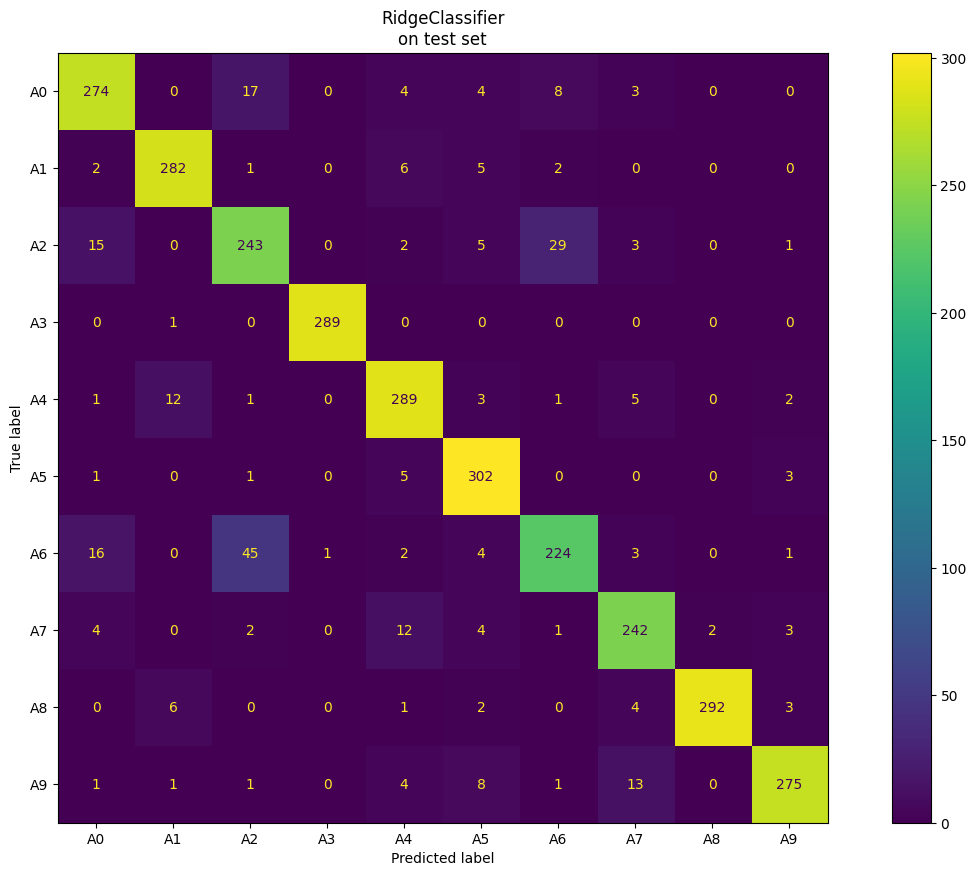

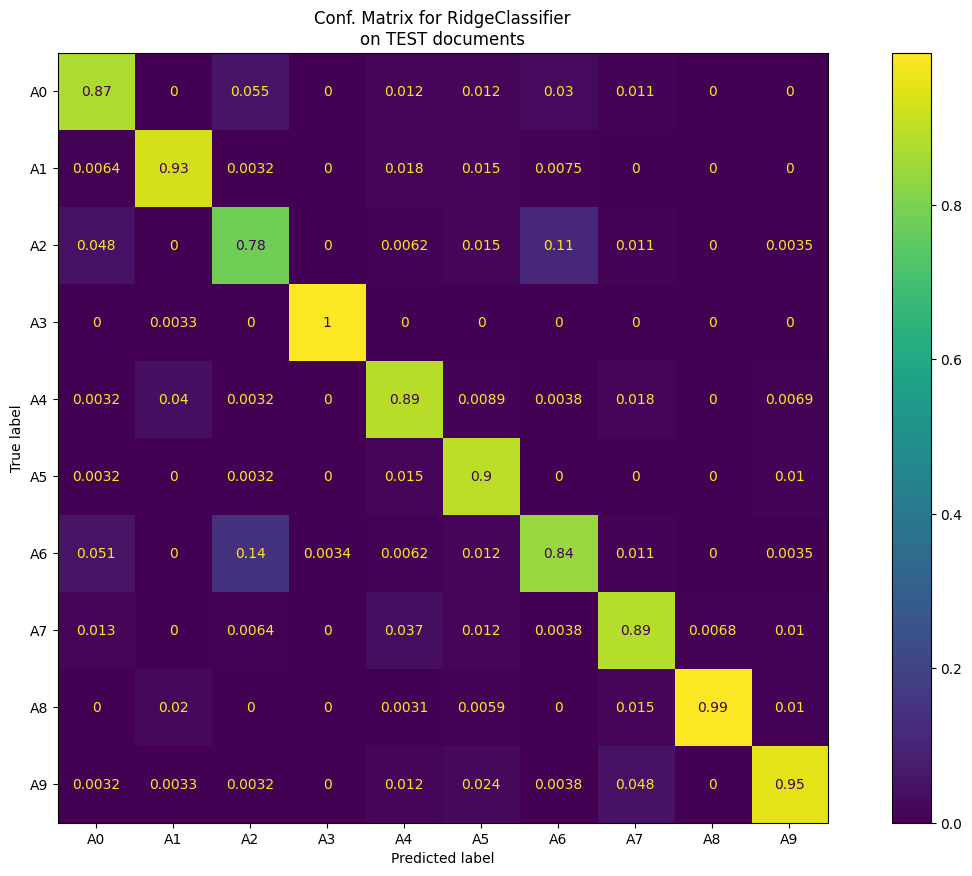


>>> Best Accuracy: (RidgeClassifier) 0.904 <<<

##########################################################################################
LogisticRegression
##########################################################################################
              precision    recall  f1-score   support

          A0       0.86      0.86      0.86       310
          A1       0.90      0.90      0.90       298
          A2       0.72      0.82      0.77       298
          A3       1.00      0.98      0.99       290
          A4       0.88      0.88      0.88       314
          A5       0.84      0.95      0.89       312
          A6       0.85      0.70      0.77       296
          A7       0.84      0.87      0.85       270
          A8       0.98      0.91      0.94       308
          A9       0.91      0.86      0.89       304

    accuracy                           0.87      3000
   macro avg       0.88      0.87      0.87      3000
weighted avg       0.88      0.87      0.87   

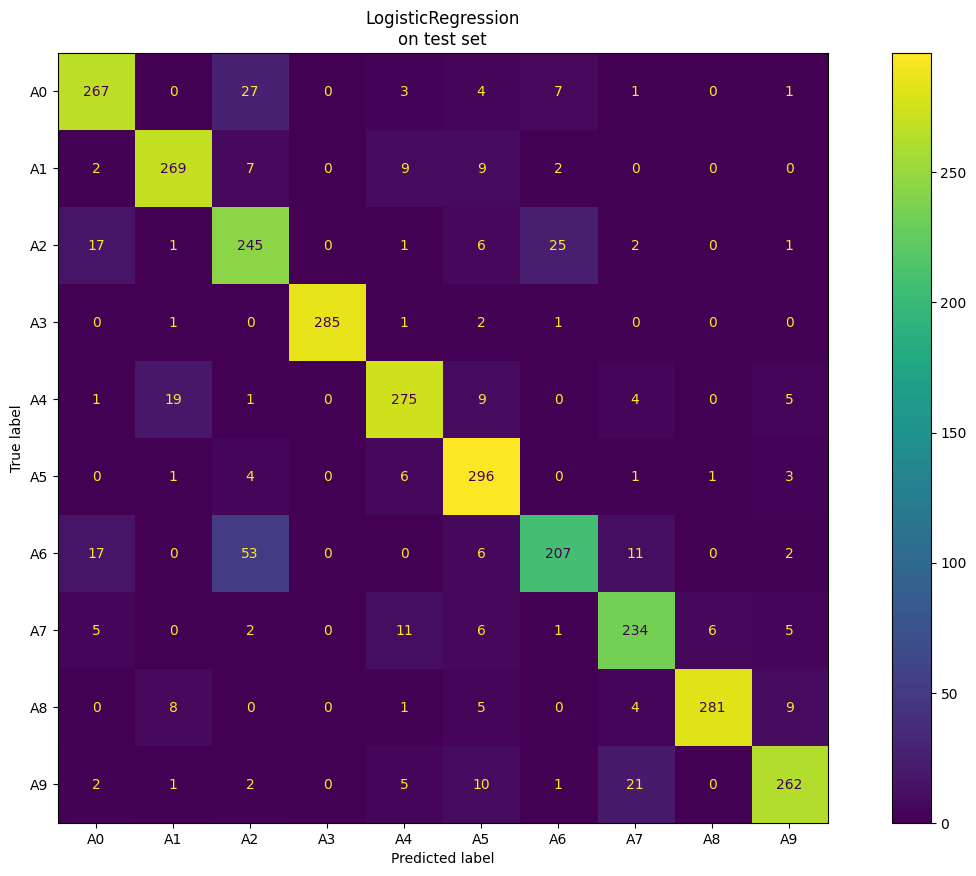

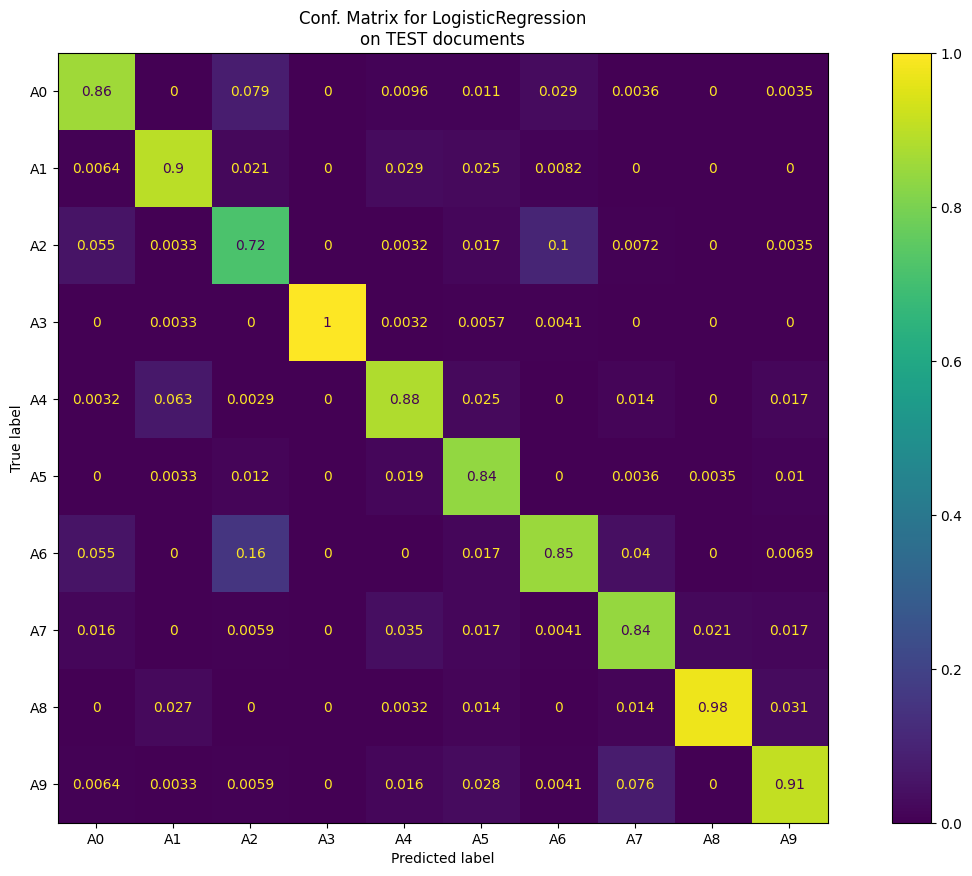


>>> Best Accuracy: (RidgeClassifier) 0.904 <<<

##########################################################################################
BernoulliNB
##########################################################################################
              precision    recall  f1-score   support

          A0       0.87      0.09      0.16       310
          A1       0.93      0.44      0.60       298
          A2       0.87      0.33      0.48       298
          A3       1.00      0.85      0.92       290
          A4       0.83      0.06      0.12       314
          A5       0.89      0.08      0.15       312
          A6       0.47      0.80      0.59       296
          A7       0.16      0.98      0.27       270
          A8       1.00      0.58      0.74       308
          A9       0.97      0.12      0.22       304

    accuracy                           0.42      3000
   macro avg       0.80      0.43      0.42      3000
weighted avg       0.81      0.42      0.42      3000

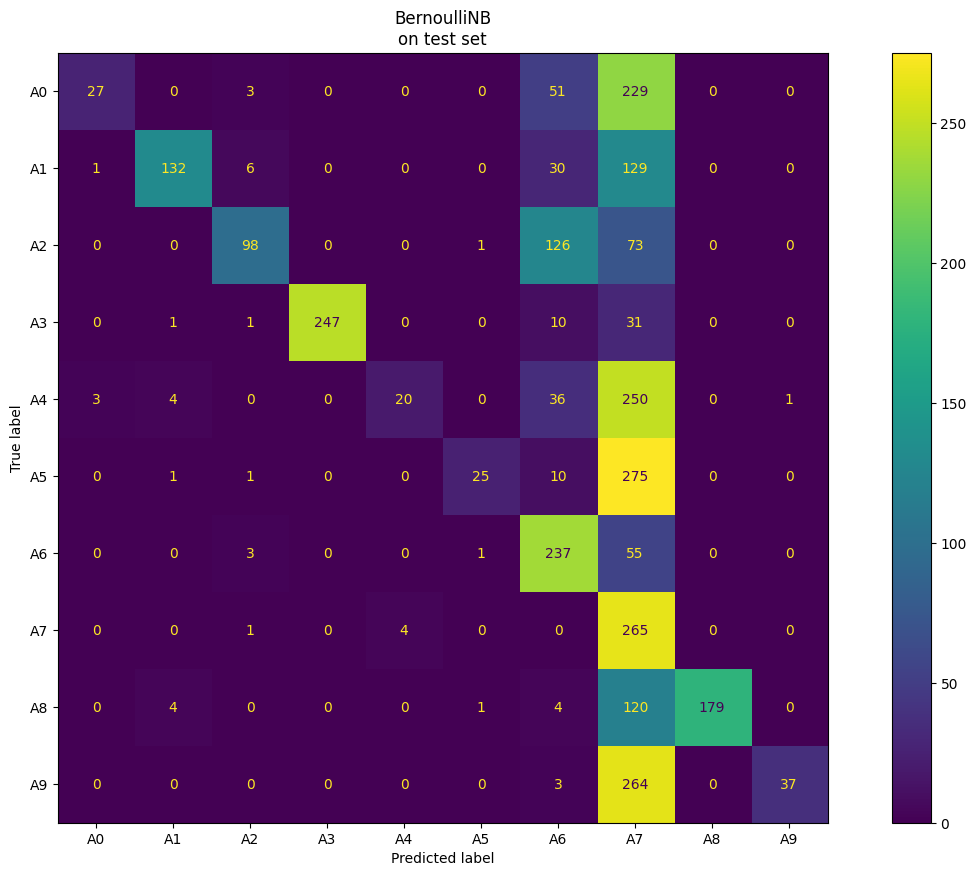

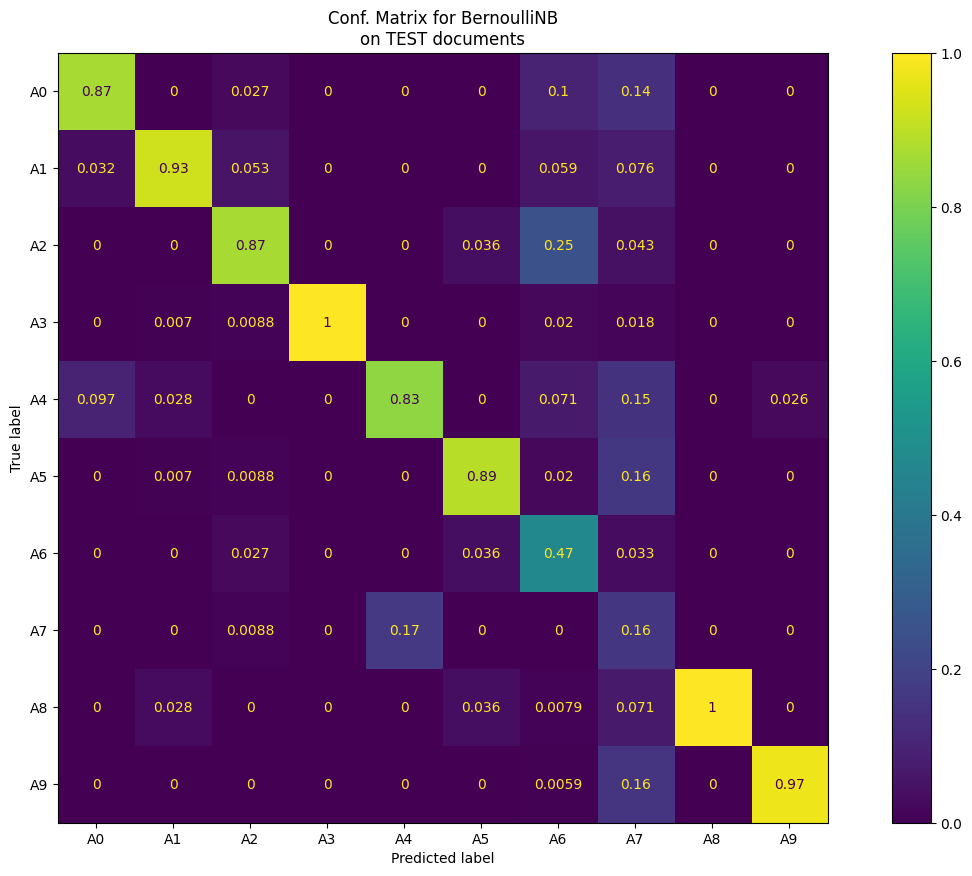


>>> Best Accuracy: (RidgeClassifier) 0.904 <<<

##########################################################################################
NearestCentroid
##########################################################################################
              precision    recall  f1-score   support

          A0       0.83      0.86      0.84       310
          A1       0.88      0.84      0.86       298
          A2       0.57      0.83      0.67       298
          A3       1.00      0.51      0.68       290
          A4       0.87      0.80      0.83       314
          A5       0.70      0.95      0.81       312
          A6       0.76      0.68      0.72       296
          A7       0.84      0.83      0.83       270
          A8       0.97      0.88      0.93       308
          A9       0.89      0.85      0.87       304

    accuracy                           0.80      3000
   macro avg       0.83      0.80      0.80      3000
weighted avg       0.83      0.80      0.80      

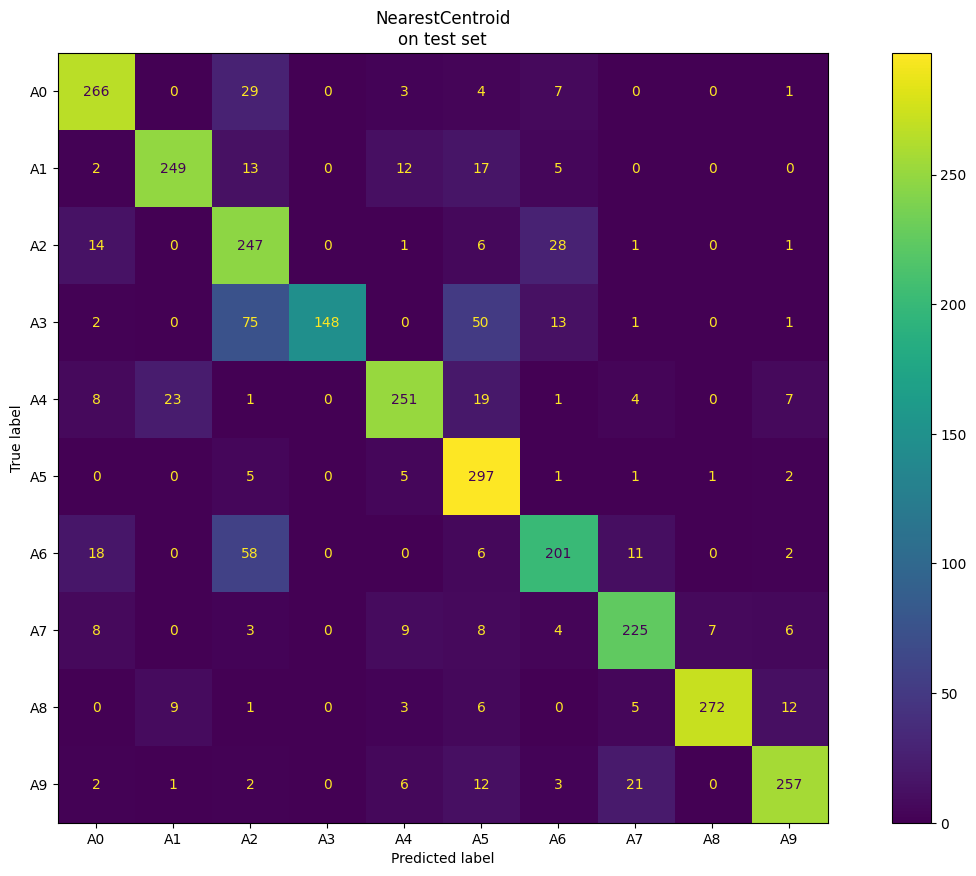

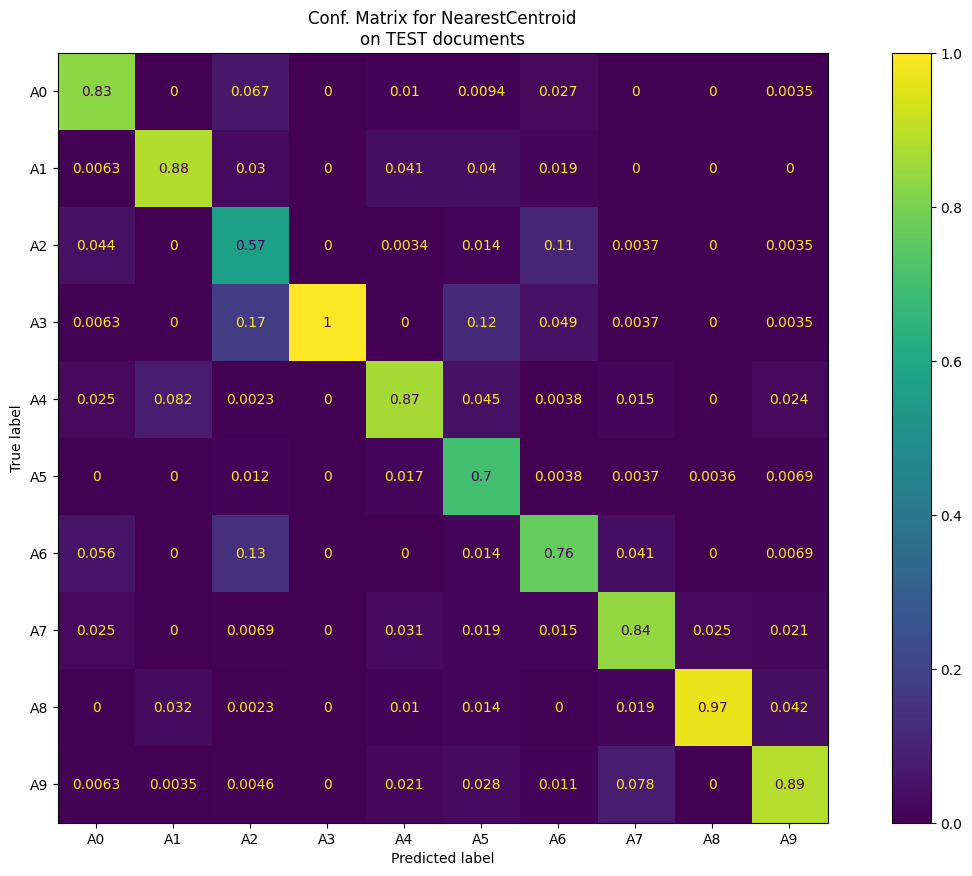


>>> Best Accuracy: (RidgeClassifier) 0.904 <<<

##########################################################################################
LinearSVC
##########################################################################################


C:\Users\joseh\AppData\Roaming\Python\Python39\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

          A0       0.88      0.88      0.88       310
          A1       0.93      0.94      0.94       298
          A2       0.79      0.81      0.80       298
          A3       0.99      1.00      0.99       290
          A4       0.89      0.92      0.90       314
          A5       0.89      0.96      0.92       312
          A6       0.85      0.75      0.80       296
          A7       0.88      0.89      0.89       270
          A8       0.99      0.95      0.97       308
          A9       0.95      0.91      0.93       304

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000

Training done in 1.403 seg. 

Creada carpeta **********

accuracy: 0.9023
balanced accuracy: 0.9019
precision (macro)   : 0.9026
precision (micro)   : 0.9023
precision (weighted): 0.9027
recall (macro)   : 0.9019
recall (micro)   : 0.9023
re

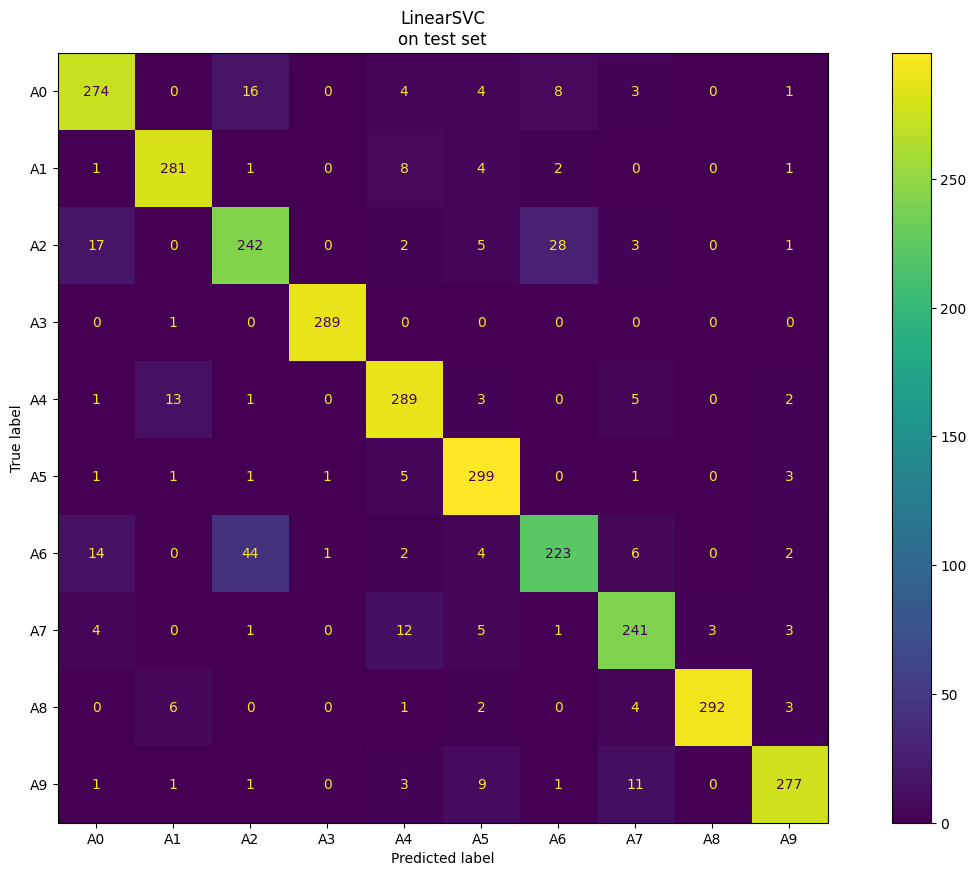

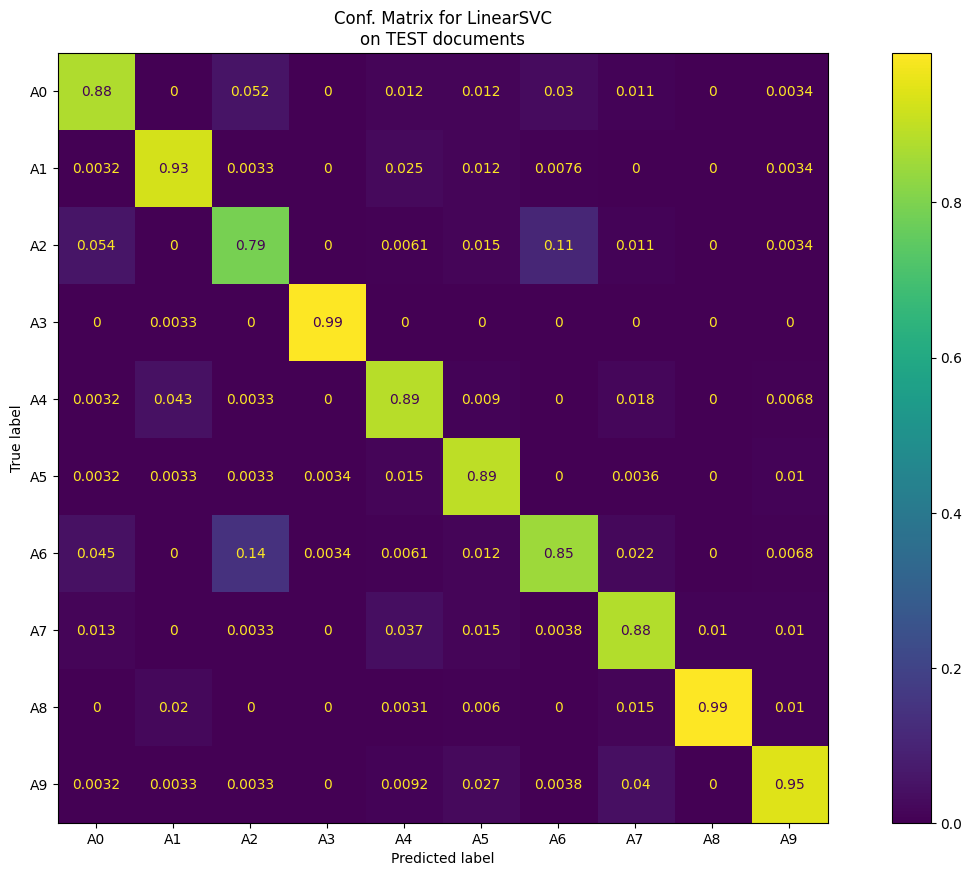


>>> Best Accuracy: (RidgeClassifier) 0.904 <<<

##########################################################################################
ExtraTreeClassifier
##########################################################################################
              precision    recall  f1-score   support

          A0       0.27      0.23      0.25       310
          A1       0.48      0.47      0.47       298
          A2       0.27      0.29      0.28       298
          A3       0.90      0.89      0.90       290
          A4       0.52      0.51      0.51       314
          A5       0.44      0.34      0.38       312
          A6       0.24      0.49      0.33       296
          A7       0.36      0.37      0.36       270
          A8       0.89      0.68      0.77       308
          A9       0.37      0.23      0.28       304

    accuracy                           0.45      3000
   macro avg       0.48      0.45      0.45      3000
weighted avg       0.48      0.45      0.45  

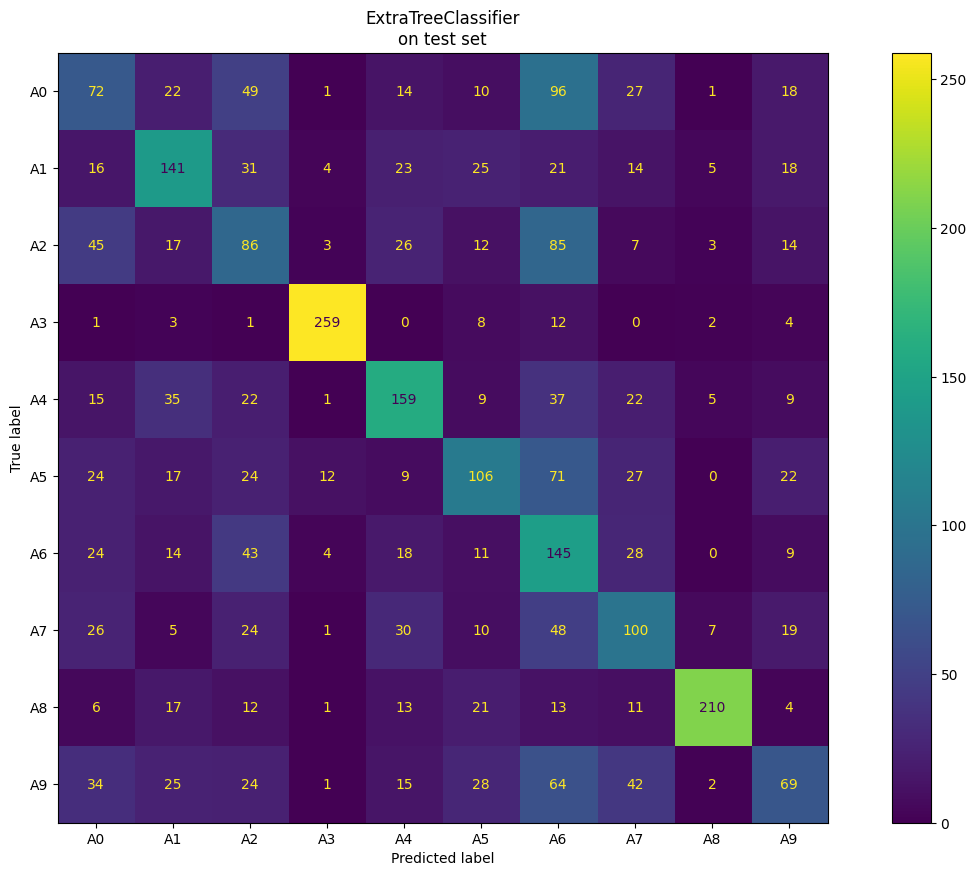

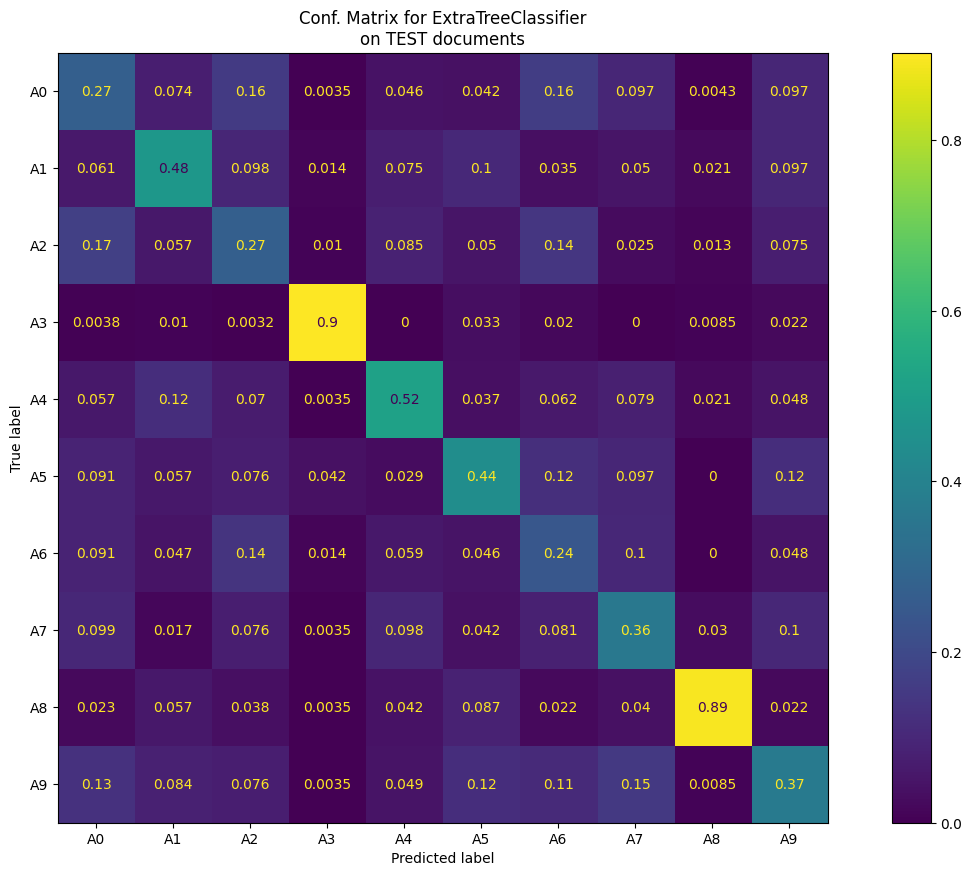


>>> Best Accuracy: (RidgeClassifier) 0.904 <<<



In [17]:

classifiers(X_train, y_train, X_test, y_test, classifiers_list, metadata, gen_conf_matrix=True)